# 환경설정

버전 : python 3.7, tensorflow 2.3.0-rc0

In [4]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf

import os
import re
import numpy as np
import pandas as pd
import pickle
import random
import collections
import json
from datetime import datetime

import sentencepiece as spm
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

### 데이터 불러오기 <br>
우선 KBO 타자 데이터를 불러오도록 한다.

링크 : https://www.kaggle.com/bluemumin/kbo-baseball-for-kaggle/version/2

In [5]:
data_path = './2019_kbo_for_kaggle_v2.csv'

In [6]:
def load_data (data_path) :
    data = pd.read_csv(data_path)
    return data 

In [7]:
data = load_data(data_path)

In [8]:
data

,batter_name,age,G,PA,AB,R,H,2B,3B,HR,...,tp,1B,FBP,avg,OBP,SLG,OPS,p_year,YAB,YOPS
0,백용환,24.0,26.0,58.0,52.0,4.0,9.0,4.0,0.0,0.0,...,포수,5.0,6.0,0.173,0.259,0.250,0.509,2014,79.0,0.580
1,백용환,25.0,47.0,86.0,79.0,8.0,14.0,2.0,0.0,4.0,...,포수,8.0,5.0,0.177,0.226,0.354,0.580,2015,154.0,0.784
2,백용환,26.0,65.0,177.0,154.0,22.0,36.0,6.0,0.0,10.0,...,포수,20.0,20.0,0.234,0.316,0.468,0.784,2016,174.0,0.581
3,백용환,27.0,80.0,199.0,174.0,12.0,34.0,7.0,0.0,4.0,...,포수,23.0,20.0,0.195,0.276,0.305,0.581,2017,17.0,0.476
4,백용환,28.0,15.0,20.0,17.0,2.0,3.0,0.0,0.0,0.0,...,포수,3.0,3.0,0.176,0.300,0.176,0.476,2018,47.0,0.691
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1908,이원석,32.0,128.0,543.0,479.0,74.0,144.0,30.0,1.0,20.0,...,3루수,93.0,59.0,0.301,0.374,0.493,0.867,2019,395.0,0.768
1909,조용호,28.0,68.0,225.0,191.0,34.0,52.0,7.0,1.0,0.0,...,우익수,44.0,28.0,0.272,0.365,0.319,0.684,2018,13.0,0.154
1910,조용호,29.0,16.0,14.0,13.0,4.0,1.0,0.0,0.0,0.0,...,우익수,1.0,0.0,0.077,0.077,0.077,0.154,2019,188.0,0.720
1911,히메네스,27.0,70.0,299.0,279.0,37.0,87.0,17.0,2.0,11.0,...,3루수,57.0,16.0,0.312,0.344,0.505,0.849,2016,523.0,0.889


위 처럼 데이터를 모두 불러오는 데 성공하였다. <br> 
각 지표에 대한 설명은 아래와 같다.

- batter_name : 선수이름
- age : 나이
- G : 경기 수
- PA : 타수
- AB : 타석 수
- R : 득점
- H : 안타
    - 진루하지 못해도 공을 치기만 한 횟수
- 2B : 2루타
    - 한번 타수에 2루타를 진출한 횟수
- 3B : 3루타
    - 한번 타수에 3루타를 진출한 횟수
- HR : 홈런
- TB : 총 루타 수
    - 1루타 + 2*2루타 + 3*3루타 + 4*홈런
- RBI : 타점
- SB : 도루 성공
    - 베이스에 있는 주자가 공과 상관없이 다음 베이스로 가는 것을 성공함
- CS : 도루 실패
    - 베이스에 있는 주자가 공과 상관없이 다음 베이스로 가는 것을 실패함
- BB : 볼넷* 수
    - 볼넷 : 타자가 타석에서 4개의 볼 카운트를 얻어내 1루로 나가는 것
- HBP : 몸에 맞은 공(데드볼 맞은 횟수)
- GB : 고의4구
    - 마지막으로 던진 볼을 포수가 발을 빼서 서서 받으면 고의사구로 기록
    - 투수가 타자의 승부를 포기했다는 의사표시를 확실하게 구분하기 위해 별도 표기
- SO : 3진
- GDP : 병살
    - 미스플레이 없이 연속으로 아웃 카운트가 두 개 생기는 경우를 뜻하며, 그러한 수비에 참여한 수비수들에게 주어지는 기록
- BU : 희생타
    - 번트
    - 요즘 번트는 득점 가능성을 떨어뜨리는 공격수단이라고 주장
    - 번트가 유용한 경우는 타격능력이 떨어져 번트 이외의 방법으로 주자를 진루시킬 능력이 없는 타자
    - 경기 최후반 1점이라도 내면 승리를 확정지을 수 있는 상황에서 그 1점이 간절히 필요할 때
- fly : 희생 플라이(희비)
- year : 해당 시즌
- salary : 해당 시즌의 연봉
- war : 대체 선수 대비 승리 기여도
- year_born : 선수가 태어난 연도
- hand2 : 타석 위치
    - 좌투우타 : 수비는 왼손으로 던지나 타석은 오른쪽에서 함.
    - 우투우타 : 수비는 오른손으로 던지고 타석은 오른쪽에서 함.
    - 좌투좌타 : 수비는 왼손으로 던지고 타석도 왼쪽에서 함.
    - 우투좌타 : 수비는 오른손으로 던지나 타석은 왼쪽에서 함.
- cp : 최근 포지션
    - 해당 시즌에 선택한 포지션
- tp : 통합 포지션
    - 기본적인 포지션
    - 지명타자 : 투수 대신 나서는 타자
    - 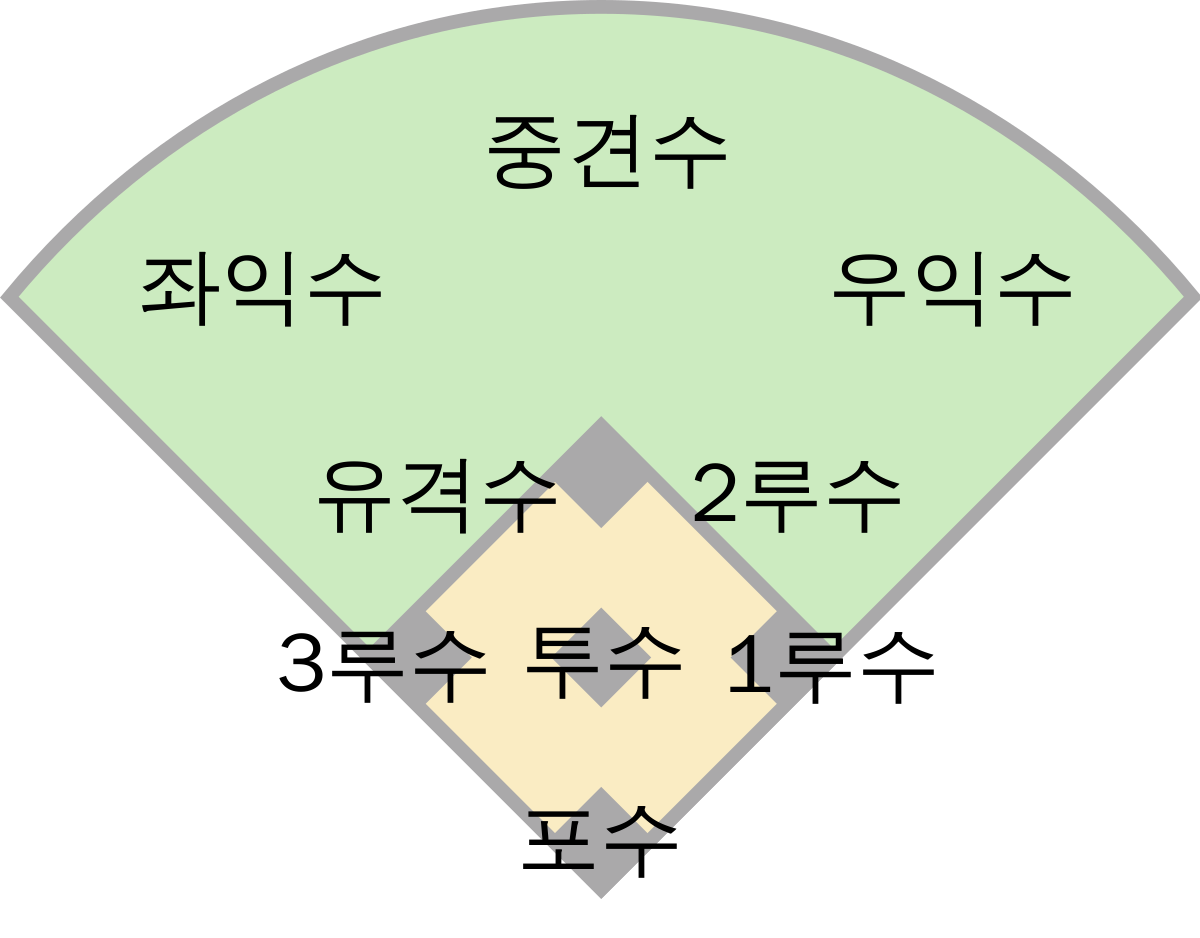
    
- 1B : 1루타
    - 한번 타수에 1루를 무사히 진출한 횟수
- FBP : BB(볼넷 수) + HBP(몸에 맞은 공)
    - Free Batting Practice프리배팅 프랙티스
    - 
- avg : 타율
    - 안타를 칠수 있는 확률
    - 타율 = (안타 / 타수)
    - BA 라고도 함.
    - 0.3 보다 높으면 좋은 타율이다. 3진 아웃되기 전에 1번은 친다는 소리이므로.
- OBP : 출루율
- SLG : 장타율
    - [1루타+ (2*2*루타) + (*3*3루타) + (4*홈런)] / 타수
- OPS : OBP(출루율) + SLG (장타율)
    - on base percentage Plus Slugging percentage(OPS(공격공헌도, On-base Plus Slugging))
    - 보통 OPS .900 이상을 좋은 선수라고 함
    - 발이 빠르고, 단타 위주의 선수는 출루율이 높지만 그런 선수는 장타율이 낮습니다. <br> 반대로 발이 느리고, 장거리 타자의 선수는 출루율이 낮지만 장타율은 높습니다. 이 점에서 기안한 지표
- p_year : 다음 시즌
- YAB : 다음 시즌 타석 수
- YOPS : 다음시즌 OPS

----------------------------------- <br>

위 지표를 활용하여 KBO 데이터를 분석할 것인데. 큰 목표는 다음과 같다.

###### 1. 나이별 기량 변화
**1번**에서는 선수의 기량이 평균적으로 어느 지점에서 떨어지는 지를 살펴 볼 것이다. <br> 

###### 2. 연봉 대 성적

**2번**에서는 선수의 성적에 비해 연봉을 얼마나 받고 있는지. <br> 
즉, 기량에 비해 덜 받고 있는지 많이 받고 있는지를 판단할 것이다. 





# 데이터 확인

우선 선수가 몇 명 있는지 확인해본다.

In [9]:
data['batter_name'].nunique()

338

In [13]:
name_length = data.groupby('batter_name').size()
name_length

batter_name
강경학      5
강동관      1
강동우     13
강민국      3
강민호     15
        ..
황선일      3
황윤호      4
황재균     10
황진수      7
히메네스     2
Length: 338, dtype: int64

In [14]:
name_length.median(), name_length.mean()

(4.0, 5.659763313609467)

In [15]:
name_length.min(), name_length.max()

(1, 19)

총 338명의 선수들이 존재하는 것을 확인할 수 있고 각자의 데이터수가 생각보다 고르지 않는 것을 볼 수 있다.

In [11]:
age_length = data.groupby('age').size()
age_length 

age
18.0     12
19.0     75
20.0     84
21.0     72
22.0     79
23.0    147
24.0    157
25.0    150
26.0    153
27.0    162
28.0    155
29.0    138
30.0    116
31.0     98
32.0     87
33.0     71
34.0     50
35.0     34
36.0     29
37.0     20
38.0     10
39.0      6
40.0      5
41.0      3
dtype: int64

In [18]:
length = data.groupby('year').size()

In [16]:
data[['batter_name','year']].groupby('year').nunique()

,batter_name
year,
1990,9
1991,6
1992,4
1993,4
1994,5
1995,8
1996,12
1997,15
1998,19


In [28]:
length.median(), length.mean()

(51.0, 65.96551724137932)

In [32]:
length.quantile(0.1)

5.800000000000001

In [26]:
data[data['year']>=2000]

,batter_name,age,G,PA,AB,R,H,2B,3B,HR,...,tp,1B,FBP,avg,OBP,SLG,OPS,p_year,YAB,YOPS
0,백용환,24.0,26.0,58.0,52.0,4.0,9.0,4.0,0.0,0.0,...,포수,5.0,6.0,0.173,0.259,0.250,0.509,2014,79.0,0.580
1,백용환,25.0,47.0,86.0,79.0,8.0,14.0,2.0,0.0,4.0,...,포수,8.0,5.0,0.177,0.226,0.354,0.580,2015,154.0,0.784
2,백용환,26.0,65.0,177.0,154.0,22.0,36.0,6.0,0.0,10.0,...,포수,20.0,20.0,0.234,0.316,0.468,0.784,2016,174.0,0.581
3,백용환,27.0,80.0,199.0,174.0,12.0,34.0,7.0,0.0,4.0,...,포수,23.0,20.0,0.195,0.276,0.305,0.581,2017,17.0,0.476
4,백용환,28.0,15.0,20.0,17.0,2.0,3.0,0.0,0.0,0.0,...,포수,3.0,3.0,0.176,0.300,0.176,0.476,2018,47.0,0.691
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1908,이원석,32.0,128.0,543.0,479.0,74.0,144.0,30.0,1.0,20.0,...,3루수,93.0,59.0,0.301,0.374,0.493,0.867,2019,395.0,0.768
1909,조용호,28.0,68.0,225.0,191.0,34.0,52.0,7.0,1.0,0.0,...,우익수,44.0,28.0,0.272,0.365,0.319,0.684,2018,13.0,0.154
1910,조용호,29.0,16.0,14.0,13.0,4.0,1.0,0.0,0.0,0.0,...,우익수,1.0,0.0,0.077,0.077,0.077,0.154,2019,188.0,0.720
1911,히메네스,27.0,70.0,299.0,279.0,37.0,87.0,17.0,2.0,11.0,...,3루수,57.0,16.0,0.312,0.344,0.505,0.849,2016,523.0,0.889


In [22]:
data.groupby('tp').size() - data.groupby('cp').size()

tp
1루수     -25
2루수      21
3루수     -30
우익수      30
유격수     103
좌익수      19
중견수      60
지명타자   -195
포수       17
dtype: int64

In [21]:
data.groupby('cp').size()

cp
1루수     212
2루수     213
3루수     243
우익수     200
유격수     135
좌익수     240
중견수     172
지명타자    268
포수      230
dtype: int64